Link: https://github.com/Marg0o0/2nd-Assingnment.git

In [240]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,accuracy_score,classification_report
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pandas



Na primeira célula de código temos a opção de selecionar o dataset a usar, podendo ser de classificação binária (diabetes, via *fetch_openml*) ou de regressão (diabetes, via *load_diabetes*).

Em seguida, procedemos à separação das variáveis independentes (X) da variável alvo (y), ou seja, aquela que queremos prever.

No caso do dataset de classificação, a variável alvo (y) sofre uma conversão das classes 'tested_negative' e 'tested_positive' em valores numéricos 0 e 1.

Por fim, verificamos as dimensões do array X (número de amostras, número de features) de forma a confirmar que são compatíveis com as dimensões esperadas do dataset fornecido.

In [241]:
# CHOOSE DATASET

# Binary classification dataset
diabetes = datasets.fetch_openml("diabetes", version = 1, as_frame = True)

# Regression dataset
#diabetes = datasets.load_diabetes( as_frame = True)

X = diabetes.data.values
#y = diabetes.target.values
#for the binary classification
y = diabetes.target.map({'tested_negative': 0, 'tested_positive': 1}).values

X.shape


(768, 8)

Nesta célula começamos por definir a percentagem de dados que será usada para teste, neste caso 20%, ficando os restantes 80% para o treino do modelo.

Os dados foram divididos em variáveis independentes (*features*) e na variável alvo (*target*), tanto para treino como para teste.

A utilização do parâmetro *random_state* assegura que a divisão seja sempre a mesma em diferentes execuções do código, garantindo a reprodutibilidade dos resultados e evitando que o modelo tenha acesso antecipado aos dados de teste.

In [242]:
#train test spliting
test_size=0.2
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=42)

Na célula seguinte aplicamos a normalização das variáveis através da classe *StandardScaler*. Cada *feature* passa a ter média 0 e desvio padrão 1, garantindo que todas as variáveis ficam na mesma escala.

Para os dados de treino usamos **fit_transform(Xtr)**, que calcula a média e o desvio padrão de cada *feature* com base nos dados de treino e aplica a transformação aos mesmos.

Para os dados de teste usamos apenas **transform(Xte)**, que aplica aos dados de teste os valores de média e desvio padrão calculados no treino. Nesta fase, o modelo não aprende nada com os dados de teste, evitando assim viciar os resultados.

In [243]:
# Standardize features
scaler=StandardScaler()
Xtr= scaler.fit_transform(Xtr)
Xte= scaler.transform(Xte)


Na próxima célula definimos o número de grupos (*clusters*) a identificar pelo algoritmo e o parâmetro de *fuzziness* (**m**), que controla se a *membership function* é mais rígida (*sharp*) ou mais difusa (*shallow*).

De seguida, juntamos as *features* de treino (**Xtr**) com a variável alvo (**ytr**), de forma a que o *clustering* considere também a variável que pretendemos prever.

Depois, transpomos a matriz de dados, uma vez que a função do **skfuzzy** espera a estrutura no formato features × amostras.

Por fim, chamamos o algoritmo **Fuzzy C-means**, passando como argumentos a matriz transposta, o número de *clusters*, o parâmetro **m**, o **error** (critério de paragem), o **maxiter** (número máximo de iterações) e o **init** (que deixa os centros serem inicializados automaticamente).

 O algoritmo devolve:
- os centros finais dos clusters,
- a matriz de *membership* **u** (grau de *membership* de cada amostra em cada *cluster*),
- a evolução da função objetivo ao longo das iterações (**jm**),
- e o índice **fpc** (*Fuzzy Partition Coefficient*), que mede a qualidade da separação dos clusters (valores próximos de 1 indicam clusters mais bem definidos).

In [244]:
 # Number of clusters 
n_clusters = 2
m=2

# Concatenate target for clustering
Xexp=np.concatenate([Xtr, ytr.reshape(-1, 1)], axis=1)

# Transpose data for skfuzzy (expects features x samples)
Xexp_T = Xexp.T 

# Fuzzy C-means clustering
centers, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    Xexp_T, n_clusters, m=m, error=0.005, maxiter=1000, init=None,
)


O comando **centers.shape** devolve as dimensões do array **centers**, correspondendo ao número de *cluster centers* encontrados (linhas) e ao número de *features* que caracterizam cada centro (colunas).

In [245]:
centers.shape

(2, 9)

Na célula seguinte criamos uma lista **sigma** para guardar a dispersão de cada *cluster*.
Para cada *cluster*, elevamos a 
**𝑚** o vetor de *memberships* de cada amostra, reforçando ou suavizando o peso de cada ponto.
Em seguida, calculamos o **desvio padrão ponderado** e guardamos o resultado em **sigma**.
Como cada ponto pode pertencer parcialmente a vários clusters, é essencial considerar o seu grau de *membership* no cálculo da dispersão — daí utilizarmos o desvio ponderado em vez do simples.
O valor de **𝜎** indica o quão espalhados estão os pontos em torno do centro do *cluster*: valores maiores significam clusters mais difusos

In [246]:
# Compute sigma (spread) for each cluster
sigmas = []
for j in range(n_clusters):
    # membership weights for cluster j, raised to m
    u_j = u[j, :] ** m
    # weighted variance for each feature
    var_j = np.average((Xexp - centers[j])**2, axis=0, weights=u_j)
    sigma_j = np.sqrt(var_j)
    sigmas.append(sigma_j)
sigmas=np.array(sigmas)


**Hard clustering**: Cada ponto é atribuido apenas a um *cluster*.

**Fuzzy clustering**: cada ponto pode pertencer parcialmente a vários *clusters*

**np.argmax**: escolhe, para cada amostra (coluna), o *cluster* (linha) onde apresenta maior *membership*. Dessa forma, o *fuzzy clustering* é convertido em *hard clustering*.

O resultado é o vetor *cluster_labels*, que contém os rótulos dos *clusters* dominantes de cada ponto (0, 1, …). Se aumentarmos o número de *clusters*, o vetor passa a ter mais valores, correspondendo às novas classes possíveis.


O gráfico apresenta esse aspeto porque a *feature* 2 (sexo) é uma variável binária. Se escolhêssemos outra *feature* contínua, a representação gráfica seria mais dispersa.

----------------------------
Relembrar:

**u** é a matriz de *memberships*, onde cada linha corresponde a um *cluster* e cada coluna a uma amostra.

(regression dataset)

u.shape = (2, 353)   
As 353 amostras corresponde à amostra de treino, as restantes 89 das 442 iniciais são para teste

-------------------------
Nota:

Usamos **axis=0** porque queremos escolher o *cluster* dominante de cada amostra (cada coluna da matriz **u**).
Se usássemos **axis=1**, estaríamos a procurar o máximo dentro de cada linha (cada *cluster*), o que não faria sentido, pois isso corresponderia a escolher apenas uma amostra para cada *cluster*.

Fuzzy partition coefficient (FPC): 0.5049354491202762


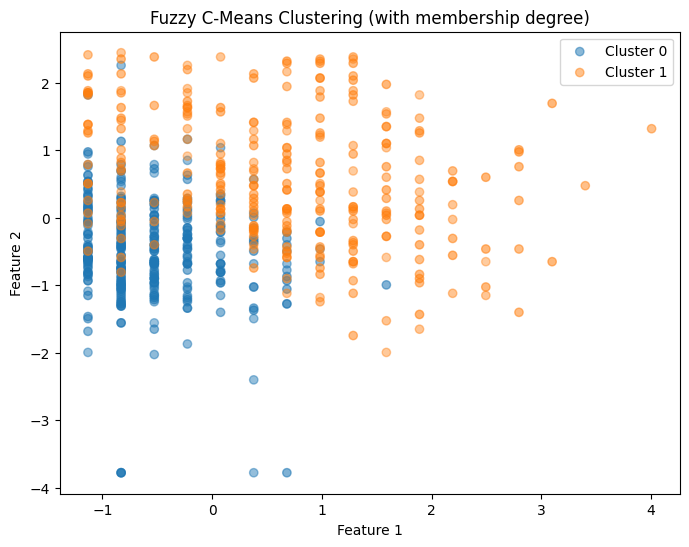

In [247]:
# Hard clustering from fuzzy membership
cluster_labels = np.argmax(u, axis=0)     
print("Fuzzy partition coefficient (FPC):", fpc)


# Plot first two features with fuzzy membership
plt.figure(figsize=(8,6))
for j in range(n_clusters):
    plt.scatter(
        Xexp[cluster_labels == j, 0],             # Feature 1
        Xexp[cluster_labels == j, 1],             # Feature 2
        alpha=u[j, :],          # transparency ~ membership
        label=f'Cluster {j}'
    )

plt.title("Fuzzy C-Means Clustering (with membership degree)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

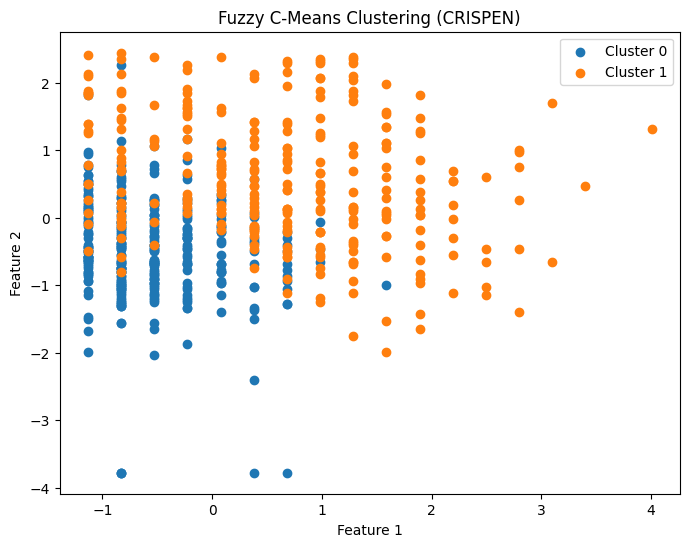

In [248]:
# Plot first two features with cluster assignments
plt.figure(figsize=(8,6))
for j in range(n_clusters):
    plt.scatter(
        Xexp[cluster_labels == j, 0],
        Xexp[cluster_labels == j, 1],
        label=f'Cluster {j}'
    )

plt.title("Fuzzy C-Means Clustering (CRISPEN)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

**Gaussian formula**: Também conhecida como função de distribuição normal, descreve a probabilidade de ocorrência de valores em torno de uma média (**𝜇**) com uma certa dispersão (**𝜎**). É muito utilizada em *fuzzy systems* para representar *memberships* ou graus de associação de um valor a um *cluster*.

A função recebe **x** (pontos onde queremos avaliar a função), **mu** (centro da Gaussiana) e **sigma** (largura da curva). Retorna o valor da da curva de Gauss para cada **x**.

**np.linspace(-2, 4, 500)** cria 500 pontos uniformemente distribuídos entre -2 e 4. Estes pontos servem como domínio da curva Gaussiana, permitindo calcular e plotar os *memberships*.

Para cada *cluster*, calcula-se a curva Gauss usando o seu centro e desvio (**sigma**). Cada curva é armazenada no array **y_aux**.

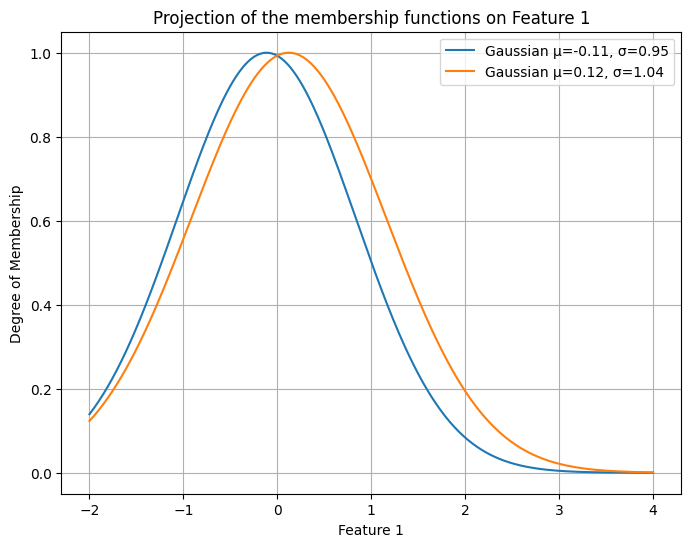

In [249]:
# Gaussian formula
def gaussian(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu)/sigma)**2)   #formula geral

lin=np.linspace(-2, 4, 500)   
plt.figure(figsize=(8,6))

y_aux=[]
for j in range(n_clusters):
# Compute curves
    y_aux.append(gaussian(lin, centers[j,0], sigmas[j,0]))

# Plot
    plt.plot(lin, y_aux[j], label=f"Gaussian μ={np.round(centers[j,0],2)}, σ={np.round(sigmas[j,0],2)}")

plt.title("Projection of the membership functions on Feature 1")
plt.xlabel("Feature 1")
plt.ylabel("Degree of Membership")
plt.legend()
plt.grid(True)
plt.show()

**GaussianMF**: representa as funções de *membership* guassianas de cada regra *fuzzy*.

Começamos por criar uma class em PyTorch.
No método  **_ init _** definimos os parâmetros do módulo que serão treináveis e configuramos a estrutura:
- **centers** → centros das curvas de Gauss para cada regra e dimensão.

- **sigmas** → desvios padrão ponderado (largura das curvas).

- **agg_prob** → define o tipo de agregação quando existem múltiplas dimensões (interseção probabilística ou mínimo *fuzzy*).

O **nn.Parameter** transforma **centers** e **sigmas** em parâmetros treináveis. O PyTorch vai atualizar automaticamente estes valores durante o treino.


O método **forward** indica como a entrada **x** é processada pelo módulo.

Calcula-se a diferença normalizada entre cada ponto e cada centro de regra (**diff**).

Procede-se à agregação entre dimensões onde:

- se **agg_prob=True** é calculada a soma quadrática das diferenças (interseção probabilística).
- se **agg_prob=True** seleciona-se o máx da diferença, (equivalente ao min *fuzzy*).

Aplica-se a **função gaussiana**, devolvendo a *membership fuzzy* de cada amostra em cada regra.

--------------------

**TSK**: a classe Tsk implementa o modelo Takagi–Sugeno–Kang, combinando funções de *membership* gaussianas nos antecedentes com funções lineares nos consequentes.

Definimos os seguintes parâmetros no **_init_**:

- **n_input** (nº de *features*)
-  **n_rules** (nº de regras *fuzzy*), 
- **centers** e **sigmas** da função de gauss
- **agg_prob** (tipo de agregação, passado para o **GaussianMF**)

Criam-se os antecedentes e os consequentes, que são funções lineares dos inputs incluindo o bias (**n_inputs + 1**). Os consequentes são inicializados aleatoriamente, através de **torch.random**, e serão ajustados durante o treino.

No método **forward** calcula-se os *memberships* de cada **input** em cada regra usando **GaussianMF**. Normaliza-se os valores para que a soma dos *memberships* seja 1, criando um peso relativo de cada regra (**norm_fs**). 

Adiciona-se o **bias** aos **inputs** (**x_aug**) e multiplicam-se pelos coeficientes das regras (**torch.einsum**) para obter a saída linear de cada regra. 

Combina-se as saídas de todas as regras ponderadas pelas *memberships* normalizadas, produzindo o **output** final (batch, 1) do sistema **TSK**.

--------------------
Nota:

**self**: representa o objeto específico ao qual um método está sendo aplicado naquele momento.


In [250]:
# ---------------------------
# Gaussian Membership Function
# ---------------------------
class GaussianMF(nn.Module):
    def __init__(self, centers, sigmas, agg_prob):
        super().__init__()      #chama o construtor da classe base
        self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.float32))
        self.sigmas = nn.Parameter(torch.tensor(sigmas, dtype=torch.float32))
        self.agg_prob=agg_prob

    def forward(self, x):
        # Expand for broadcasting
        # x: (batch, 1, n_dims), centers: (1, n_rules, n_dims), sigmas: (1, n_rules, n_dims)
        diff = abs((x.unsqueeze(1) - self.centers.unsqueeze(0))/self.sigmas.unsqueeze(0)) #(batch, n_rules, n_dims)

        # Aggregation
        if self.agg_prob:
            dist = torch.norm(diff, dim=-1)  # (batch, n_rules) # probablistic intersection
        else:
            dist = torch.max(diff, dim=-1).values  # (batch, n_rules) # min intersection (min instersection of normal funtion is the same as the max on dist)
        
        #aplica a funçao de gauss para transformar a distancia numa pertinecia fuzzy
        return torch.exp(-0.5 * dist ** 2)  


# ---------------------------
# TSK Model
# ---------------------------
class TSK(nn.Module):
    def __init__(self, n_inputs, n_rules, centers, sigmas,agg_prob=False):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_rules = n_rules

        # Antecedents (Gaussian MFs)
        
        self.mfs=GaussianMF(centers, sigmas,agg_prob) 

        # Consequents (linear functions of inputs)
        # Each rule has coeffs for each input + bias
        self.consequents = nn.Parameter(
            torch.randn(n_inputs + 1,n_rules)
        )

    def forward(self, x):
        # x: (batch, n_inputs)
        batch_size = x.shape[0]
        
        # Compute membership values for each input feature
        # firing_strengths: (batch, n_rules)
        firing_strengths = self.mfs(x)
        
        # Normalize memberships
        # norm_fs: (batch, n_rules)
        norm_fs = firing_strengths / (firing_strengths.sum(dim=1, keepdim=True) + 1e-9)

        # Consequent output (linear model per rule)
        x_aug = torch.cat([x, torch.ones(batch_size, 1)], dim=1)  # add bias

        rule_outputs = torch.einsum("br,rk->bk", x_aug, self.consequents)  # (batch, rules)
        # Weighted sum
        output = torch.sum(norm_fs * rule_outputs, dim=1, keepdim=True)

        return output, norm_fs, rule_outputs



O objetivo da próxima célula é treinar os consequentes lineares do **TSK** usando **Least Squares**. Este método é mais rápido e direto pois só resolve os consequentes linearmente sem treinar todos os parâmetros

Começa-se por calcular os firing strenghts normalizados (**norm_fs**) para cada input e regra.

Cria-se uma matriz **phi** que combina inputs e firing strenghts, sendo que cada linha representa uma amostra ponderada pelas regras.
**torch.einsum("br,bi->bri", X_aug, norm_fs)** multiplica cada input pelo firing strenght de cada regra:
- **br**: batch x regras
- **bi**: batch x features + 1 (bias: termo constante)
- resultado **bri**: batch x regras x features + 1

Depois resolve se um problema de **Least Squares** para encontrar os coeficientes lineares que melhor aproximam a saída desejada **y**. O vetor **theta** contém todos os coeficientes lineares de todas as regras.

Atualiza-se os consequentes do modelo **TSK** diretamente (sem usar backpropagation)


---------
Nota:

- **torch.no.grad()**: desliga o cálculo de gradientes, porque neste caso o treino não será via backpropagation.
- **model(x)**: passa os dados pelo TSK para obter firing strengths normalizados (**norm_fs**). A saída do modelo e das regras não são usadas aqui.

- **firing strengths**: graus de ativação das regras, funcionam como pesos relativos na combinação das saídas das regras (quanto maior mais influência tem). Uma regra só "participa" se a amostra estiver próxima do centro da sua gaussiana.


In [251]:
# Least Squares Solver for Consequents (TSK)
# ---------------------------
def train_ls(model, X, y):   
    with torch.no_grad():
        _, norm_fs, _ = model(X)

        # Design matrix for LS: combine normalized firing strengths with input
        X_aug = torch.cat([X, torch.ones(X.shape[0], 1)], dim=1)
        
        Phi = torch.einsum("br,bi->bri", X_aug, norm_fs).reshape(X.shape[0], -1)
        
        # Solve LS: consequents = (Phi^T Phi)^-1 Phi^T y
        
        theta= torch.linalg.lstsq(Phi, y).solution
    
        
        model.consequents.data = theta.reshape(model.consequents.shape)
# ---------------------------

    


A função na célula seguinte serve para treinar todos os parâmetros do **TSK** usando **Gradient Descent**, um método alternativo ao **Least Squares**.

Utiliza-se o otimizador **Adam**, um algoritmo de otimização baseado em gradiente.
Com **model.parameters()** incluímos todos os parâmeteos treináveis: **centers** e **sigmas** da **GaussianMF** e **consequents** do **TSK**.

A função de perda escolhida é o **erro quadrático médio** (**MSE**) entre a saída prevista (**y_pred**) e a saída desejada (**y**).

Depois através de um loop de treino, os parâmetros são ajustados iterativamente para minimizar a função de perda, atualizando todos os parâmetros do modelo.

----------------
Dúvidas?:
- Step by step  gradient descent

https://www.youtube.com/watch?v=sDv4f4s2SB8


In [252]:
# ---------------------------
# Gradient Descent Training 
# ---------------------------
def train_gd(model, X, y, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    for _ in range(epochs):
        optimizer.zero_grad()        #zera os gradientes acumulados
        y_pred, _, _ = model(X)      #passa o input pelo TSK
        loss = criterion(y_pred, y)  #calculo do erro
        print(loss)                  #imprime a perda
        loss.backward()              #calcula gradientes via backpropagation
        optimizer.step()             #atualiza os parâmetros


O ANFIS (Sistema de inferência Neuro-Fuzzy Adaptativa) combina as capacidades de uma rede neural artificial com as de um sistema de lógica fuzzy.
Tanto o sistema ANFIS ou TSK criam os clusters pelo mesmo processo e têm a fase de treino para os consequentes feita com Least squares. O ANFIS treina também os antecedentes, permitindo adaptar as regras ao longo do treino.

Composto por 5 layers:
1. Fuzzification (input layer): Coverte crisp inputs em fuzzy values, estabelece valores de membership a cada input;
2. Rule evaluation: calcula a firing strength de cada regra
3. Normalization: normaliza as firing strengths
4. Defuzzification: calcula o output de cada regra. Cada output é pesado pela normalização da firing strength calculada na camada anterior
5. Output layer:soma os outputs ponderados das regras para gerar a saída final

- Estas camadas são comuns ao sistema TSK. A diferença é que no ANFIS as mesmas são organizadas em camadas neurais, o que permite o treino via backpropagation+least squares. No TSK "puro" os parametros são normalmente definidos por especialistas ou metodos clustering.


**Hybrid Learning**:
- Otimiza dois conjuntos de parâmetros(MFs parameters e Consequent parameters)

O processo tem duas partes que dependem uma da outra sendo o treino feito em ciclos, neste caso 20 **(max_iters = 20)**.

- Step A: Atualização dos antecedentes via *gradient descent* **(train_gd)**. durante **gd_epochs** passagens pelo dataset.
- Step B: Atualização dos consequentes via *least squares* **(train_ls)** 

Esta etapa final é a que temos presente na célula seguinte onde podemos ver o treino dos antecedentes e depois dos consequentes.




----------------------------------------------------
Nota:
- **rede neural artificial**: permite aprender com os dados e modelar funções não lineares. Usada para otimizar os parametros baseado on data (both memberships functions and fuzzy parameters)
- **sistema de lógica fuzzy**: permite lidar com a imprecisão e incerteza dos dados. Usada para modelar a função em termos linguisticos ("baixo", "médio", "alto")

- **gd_epochs**: quantas passagens completas pelo dataset vai usar dentro da etapa GD.
- **lr**: *learning rate*, tamanho do passo do gradiente em cada atualização. Quanto mais elevado o valor mais rápida é a aprendizagem, mas um valor demasiado elevado pode tornar o treino instavel ao saltar o ponto otimo/minimo, como um carro que faz uma curva a uma velocidade muito eelevada.

- a função na célula abaixo começa por correr a função do least squares para definir os consequentes e depois sim corre o ciclo de otimizar antecedentes- consequentes- antecedentes- consequentes...

------------------------------------------
Fontes:
- Explicação do funcionamento do sistema ANFIS passo a passo

https://medium.com/@adnan.mazraeh1993/anfis-adaptive-neuro-fuzzy-inference-system-abbba3ecb68f


In [253]:
# ---------------------------
# Hybrid Training (Classic ANFIS)
# ---------------------------
def train_hybrid_anfis(model, X, y, max_iters=20, gd_epochs=30, lr=1e-4):
    train_ls(model, X, y)
    for _ in range(max_iters):
        # Step A: GD on antecedents (freeze consequents)
        model.consequents.requires_grad = False   
        train_gd(model, X, y, epochs=gd_epochs, lr=lr)

        # Step B: LS on consequents (freeze antecedents)
        model.consequents.requires_grad = True
        model.mfs.requires_grad = False
        train_ls(model, X, y)  

        # Re-enable antecedents
        model.mfs.requires_grad = True

Na célula abaixo temos um método alternativo de treino híbrido. Primeiro usamos o **Least Squares** para ajustar os consequentes, e em seguida aplicamos o **Gradient Descent** para refinar tanto os antecedentes como os consequentes.

In [254]:
# ---------------------------
# Alternative Hybrid Training (LS+ gradient descent on all)
# ---------------------------
def train_hybrid(model, X, y, epochs=100, lr=1e-4):
    # Step 1: LS for consequents
    train_ls(model, X, y)
    # Step 2: GD fine-tuning
    train_gd(model, X, y, epochs=epochs, lr=lr)
    


Na primeira linha da próxima célula criamos o modelo TSK definindo:
- o nº de *features* de entrada (**n_inputs=Xtr.shape[1]**)
- o nº de regras *fuzzy*, definidas pelo nº de clusters escolhidos (**n_rules=n_clusters**)
- e selecionando os **centers** e **sigmas** das funçoes de gauss para cada regra

Desta forma temos o modelo com antecedentes gaussianos e consequentes lineares inicializados aleatoriamente

Na restantes linhas de código da célula temos a conversão dos dados para tensores de PyTorch. Este passo é necessário para que o modelo possa processar os dados e calcular gradientes ou **Least Squares**

In [255]:
# Build model
model = TSK(n_inputs=Xtr.shape[1], n_rules=n_clusters, centers=centers[:,:-1], sigmas=sigmas[:,:-1])

Xtr = torch.tensor(Xtr, dtype=torch.float32)
ytr = torch.tensor(ytr, dtype=torch.float32)
Xte = torch.tensor(Xte, dtype=torch.float32)
yte = torch.tensor(yte, dtype=torch.float32)


Aqui chamamos a função de treino por *Anfis*, com os seguintes inputs:
- o modelo **hybrid anfis**, criado na célula anterior
- os *features*, já convertidos para tensores PyTorch
- e **ytr.reshape(-1,1)**,  para garantir que **ytr** tem dimensão correta para o cálculo do **Least Squares**, ou seja, **(n_amostras, 1)**


In [256]:
# Training with hybrid anfis:
train_hybrid_anfis(model, Xtr, ytr.reshape(-1,1), max_iters = 20, gd_epochs = 20, lr = 1e-3)

tensor(0.1524, grad_fn=<MseLossBackward0>)
tensor(0.1522, grad_fn=<MseLossBackward0>)
tensor(0.1520, grad_fn=<MseLossBackward0>)
tensor(0.1519, grad_fn=<MseLossBackward0>)
tensor(0.1517, grad_fn=<MseLossBackward0>)
tensor(0.1516, grad_fn=<MseLossBackward0>)
tensor(0.1514, grad_fn=<MseLossBackward0>)
tensor(0.1513, grad_fn=<MseLossBackward0>)
tensor(0.1512, grad_fn=<MseLossBackward0>)
tensor(0.1511, grad_fn=<MseLossBackward0>)
tensor(0.1510, grad_fn=<MseLossBackward0>)
tensor(0.1509, grad_fn=<MseLossBackward0>)
tensor(0.1509, grad_fn=<MseLossBackward0>)
tensor(0.1508, grad_fn=<MseLossBackward0>)
tensor(0.1507, grad_fn=<MseLossBackward0>)
tensor(0.1507, grad_fn=<MseLossBackward0>)
tensor(0.1506, grad_fn=<MseLossBackward0>)
tensor(0.1506, grad_fn=<MseLossBackward0>)
tensor(0.1505, grad_fn=<MseLossBackward0>)
tensor(0.1505, grad_fn=<MseLossBackward0>)
tensor(0.1480, grad_fn=<MseLossBackward0>)
tensor(0.1477, grad_fn=<MseLossBackward0>)
tensor(0.1475, grad_fn=<MseLossBackward0>)
tensor(0.14

Nesta ultima célula passamos os dados de teste (**Xte**) pelo modelo **Anfis**

Dependendo do dataset (regressão ou classificação binária) temos duas respostas possíveis:

- Dataset de classificação binária:
   - calcula a **accuracy**, ou seja, a proporção de previsões corretas em relação ao **yte**
   - (**y_pred.detach().numpy()>0.5** : converte a previsão contínua do TSK em classe 0 ou 1, com threshold = 0.5)

- Dataset de regressão:
  - calcula o **Mean Square Error** (**MSE**) entre a saída prevista e a saída real
  - (converte **yte** e **y_pred** para numpy arrays, usando **.detach().numpy()**) 


-----------------
Nota:

- Em **y_pred, _, _ = model(Xte)**:
   - a **y_pred** é a saída prevista pelo modelo para cada amostra teste
   - **_** ignora os firing strengths e saídas intermediárias, que não são usados aqui

- **threshold**: funciona como um valor de "corte" para decidir a que classe pertence o valor, quando temos classificação binária mas saída continua.
 Exemplo:
   - y_pred = 0.7 -> classe 1
   - y_pred = 0.3 -> classe 0


In [257]:
y_pred, _, _=model(Xte)
#performance metric for classification
print(f'ACC:{accuracy_score(yte.detach().numpy(),y_pred.detach().numpy()>0.5)}') #classification

#performance metric for regression
#print(f'MSE:{mean_squared_error(yte.detach().numpy(),y_pred.detach().numpy())}') #regression

ACC:0.7402597402597403
